# PCA of multiple molecules

In [1]:
import matplotlib.pyplot as plt
import xarray as xr

import shnitsel as sh
import shnitsel.xarray

In [2]:
A01 = sh.open_frames('/nc/reports/2025-05-21_datasheets/filtered_C2H4.nc')
I01 = sh.open_frames('/nc/SHNITSEL_databases/dynamic/I01_ch2nh2_dynamic.nc')
A02 = sh.open_frames('/nc/reports/2025-05-21_datasheets/filtered_C3H6.nc')
A03 = sh.open_frames('/nc/reports/2025-05-21_datasheets/filtered_C4H8_g0.nc')

In [3]:
def vis(frames, charge=0):
    mol = sh.dynamic.filter_unphysical.mol_from_atXYZ(
        frames.atXYZ.isel(frame=0), charge=charge, to2D=True
    )
    for atom in mol.GetAtoms():
        atom.SetProp("atomNote", str(atom.GetIdx()))
    return mol

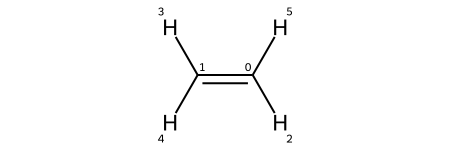

In [4]:
vis(A01, 0)

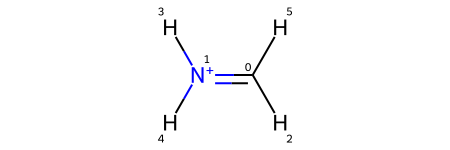

In [5]:
vis(I01, +1)

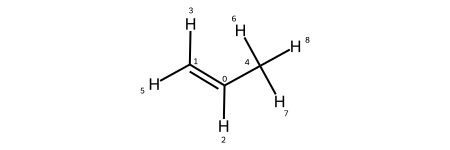

In [6]:
vis(A02)

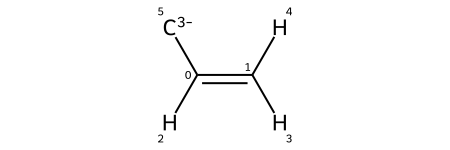

In [7]:
# Renumber: 4 <-> 5
A02new = A02.isel(atom=slice(0,6)).assign_coords(atom=[0, 1, 2, 3, 5, 4]).sortby('atom')
vis(A02new, -3)

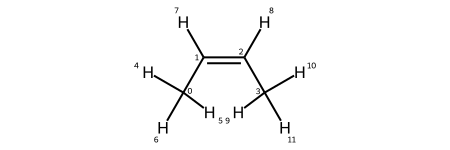

In [8]:
vis(A03)

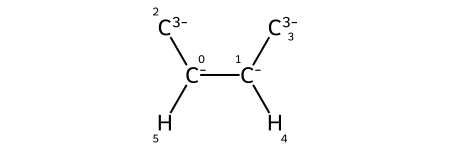

In [9]:
# Renumber: 0->3, 1->1, 2->0, 3->2, 4->4, 5->5,
A03new = A03.isel(atom=[0,1,2,3,7,8]).assign_coords(atom=[3, 1, 0, 2, 4, 5]).sortby('atom')
vis(A03new, -8)

In [10]:
homologs = xr.concat(
    [
        A01.sh.expand_midx('frame', 'cmpnd', 'A01'),
        I01.sh.expand_midx('frame', 'cmpnd', 'I01'),
        A02new.sh.expand_midx('frame', 'cmpnd', 'A02'),
        A03new.sh.expand_midx('frame', 'cmpnd', 'A03')
    ],
    dim='frame',
    coords='minimal',
    compat='override'
)
homologs

<xarray.Dataset> Size: 2GB
Dimensions:    (state: 3, frame: 151874, direction: 3, statecomb: 3, atom: 6,
                trajid_: 555, state2: 3)
Coordinates: (12/13)
  * state      (state) int64 24B 1 2 3
  * state2     (state2) int64 24B 1 2 3
  * atom       (atom) int64 48B 0 1 2 3 4 5
  * direction  (direction) <U1 12B 'x' 'y' 'z'
  * trajid_    (trajid_) int32 2kB 2 3 4 6 8 9 10 ... 955 956 957 961 962 969
  * statecomb  (statecomb) object 24B MultiIndex
    ...         ...
  * to         (statecomb) int64 24B 2 3 3
  * frame      (frame) object 1MB MultiIndex
  * cmpnd      (frame) object 1MB 'A01' 'A01' 'A01' 'A01' ... 'A03' 'A03' 'A03'
  * trajid     (frame) int64 1MB 2 2 2 2 2 2 2 2 ... 316 316 316 316 316 316 316
  * time       (frame) float64 1MB 0.0 0.5 1.0 1.5 2.0 ... 76.5 77.0 77.5 78.0
    atNames    (atom) <U1 24B 'C' 'C' 'H' 'H' 'H' 'H'
Data variables: (12/13)
    energy     (state, frame) float64 4MB 0.8285 0.6196 0.3822 ... 15.66 15.52
    e_kin      (frame) float64 1MB 0.1839 0.4249 0.7293 ... 6.936 7.527 8.137
    dip_perm   (state, direction, frame) float64 11MB 0.005891 ... -0.01176
    dip_trans  (statecomb, direction, frame) float64 11MB -1.421 ... 0.7723
    sdiag      (frame) int64 1MB 2 2 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1 1 1 1
    astate     (frame) int64 1MB 2 2 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1 1 1 1
    ...         ...
    phases     (state, frame) float64 4MB -1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    nacs       (statecomb, atom, direction, frame) float64 66MB -0.2649 ... -...
    atXYZ      (atom, direction, frame) float64 22MB 0.003451 ... -1.382
    max_ts     (frame, trajid_) float64 674MB 400.0 400.0 400.0 ... nan nan nan
    completed  (frame, trajid_) float32 337MB 1.0 1.0 1.0 nan ... nan nan nan
    nsteps     (frame, trajid_) float64 674MB 401.0 401.0 401.0 ... nan nan nan
Attributes:
    delta_t:  0.5

In [12]:
pwdist = homologs.atXYZ.sh.subtract_combinations('atom').sh.norm('direction')
pca = pwdist.sh.pca('atomcomb')

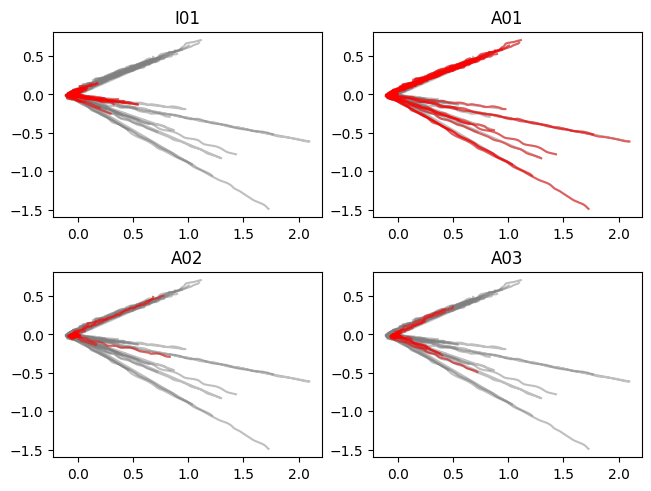

In [13]:
fig, axs = plt.subplot_mosaic([['I01', 'A01'],['A02', 'A03']], layout='constrained')

# grey background
for ax in axs.values():
    for _, traj in pca.groupby('trajid'):
        ax.plot(traj[:,0], traj[:,1], c='gray', alpha=0.5)

for name, cmpnd in pca.groupby('cmpnd'):
    ax = axs[name]
    for _, traj in cmpnd.groupby('trajid'):
        ax.plot(traj[:,0], traj[:,1], c='red', alpha=0.5)
    ax.set_title(name)


# Identify clusters
Over all homologs/isoelectronics

## 1. On the frame level

### 1.1 $k$-means on frames before PCA

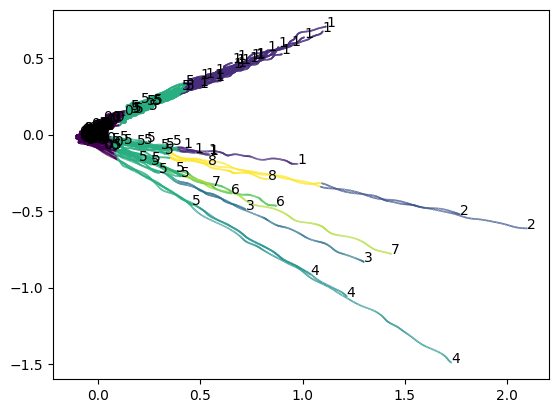

In [18]:
from sklearn.cluster import KMeans
kmc = KMeans(n_clusters=9)
pwdist = pwdist.transpose('frame', 'atomcomb')
kmc.fit(pwdist)
res_kmc = kmc.predict(pwdist)
pca['cluster'] = 'frame', res_kmc

plt.scatter(pca[:,0], pca[:,1], c=res_kmc, s=0.1)
for lcmpnd, cmpnd in pca.groupby('cmpnd'):
    for ltraj, traj in cmpnd.groupby('trajid'):
        point = traj.isel(frame=-1)
        plt.text(point.item(0), point.item(1), point.cluster.item())